# **Solving Optimization Problems on Real Quantum Machines**
---

**Bernardo Silva 93365**

**Introduction to Quantum Information and Computation, 2021/22**

**Instituto Superior Técnico, Universidade de Lisboa**

**January 31, 2022**

## Why Use Quantum Annealing?
[1]

- Very natural problem formulation for **Optimization problems** and **Sampling problems**;
- Could also be useful for **Simulation problems**;
- Current implementations are competing against their classical counterparts for the biggest speedups;
- This paradigm handles noise better than the circuit model, which allows for a much greater (1 order of magnitude) number of qubits currently implemented;
- It's the closest we have to the theoretical universal model of Quantum Adiabatic Computing;
- It's pretty cool. 

L## D-Wave's Implementation

![DWave logo](images/dwave.png)

**D-Wave** is a Canadian company that built some systems capable of performing Quantum Annealing. 

**Qubits** are implemented as **superconducting loops**, where the direction of the current dictates the state the qubit is is.

**Magnetic fields** control the **biases** of individual qubits, and **couplers** control the strength of qubit-qubit interactions (**entanglement**). 

**Qubits** are arranged in a certain **topology** that dictates the degrees of connection of the qubits. In the following images, a loop represents one qubit and one intersection represents a coupling.

---
**Chimera topology:**
- Each qubit is connected to 6 other qubits
- It presents a $16\times16$ grid of unit cells (3 represented in the figure bellow), each with 8 qubits

![Chimera topology](images/chimera.png)

**Pegasus topology:**
- Each qubit is connected to 15 other qubits

![Pegasus topology](images/pegasus.png)

---

Since these graphs are not totally connected, sometimes we need to represent a variable using multiple qubits and setting a strong interaction between them to ensure they result in the same values. 

The process of mapping variables to qubits is called **minor embedding** [2]. More on this later.



|                           | D-Wave One | D-Wave Two | D-Wave 2X   | D-Wave 2000Q | Advantage | Advantage 2  |
|:-------------------------:|:----------:|:----------:|-------------|--------------|-----------|--------------|
| Release date              |  May 2011  |  May 2013  | August 2015 | January 2017 |    2020   | 2023-2024    |
| Topology                  |            |            |             |    Chimera   |  Pegasus  |    Zephyr    |
| Qubits                    |     128    |     512    |     1152    |     2048     |    5640   | 7000+ |
| Couplers                  |     352    |    1,472   |    3,360    |     6,016    |   40,484  |              |
| Temperature (K) |            |    0.02    |    0.015    |     0.015    |   <0.015  |              |
| Power (kW)    |            |    15.5    |      25     |      25      |     25    |              |

D-Wave provides a quantum cloud service, **Leap™**, and a suite of open-source tools, **Ocean**, for interacting with the QPUs.

Anyone can program and run their programs on the quantum hardware (up to a certain quota).

The Documentation for the Ocean's Python Libraries used can be found [here](https://docs.ocean.dwavesys.com/) [3].

# Optimization Problems

In general, an optimization problem is one where we want to minimize/maximize a given function, sometimes called cost function or objective function.

D-Waves's machines allow us to solve **quadratic models**, that is, where the interactions are, at most, between two variables (qubits).

**Binary Quadratic Models:**

The general equation to represent this model is 

$$E(\mathbf v) = \sum_i a_i\mathbf{v_i} + \sum_{i<j} b_{i,j}\mathbf{v_i}\mathbf{v_j}, \quad \mathbf{v_i} \in \{-1,1\}\ \text{or}\ \mathbf{v_i} \in \{0,1\}$$

When $\mathbf{v_i} \in \{-1,1\}$, we call it the **Ising Model**, and when $\mathbf{v_i} \in \{0,1\}$, we call it a **Quadratic Unconstrained Binary Model (QUBO)**.

These models are unconstrained because we can't enforce constraints on the variables, we can only penalize them.

## (Anti)Ferromagnetic Chain
[4 - Raúl's Presentation]

![chain](images/cadeia.png)

Lets look at the spin chain example again. Here we consider the Ising model for a chain of $N$ qubits with couplings set to either $1$ or $-1$.

In [1]:
from dimod import BinaryQuadraticModel

#Samplers
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

import dwave.inspector

In [11]:
# Build the BQM
N = 50
COUPLING = -1

bqm = BinaryQuadraticModel(N,'SPIN')

for i in range(N-1):
    bqm.set_quadratic(i, i+1, COUPLING)
bqm.set_quadratic(0, N-1, COUPLING)

In [12]:
sampler = EmbeddingComposite(DWaveSampler()) #QPU sampler
# sampler = SimulatedAnnealingSampler() #Simulated annealing sampler

samples = sampler.sample(bqm, num_reads=100, label='Spins')

energies = [s.energy for s in samples.data()]
occurences = [s.num_occurrences for s in samples.data()]

In [4]:
#Inspect the embedding
dwave.inspector.show(samples)  

'http://127.0.0.1:18000/?problemId=4a9d1403-219e-4dfd-b2e2-9ed63204681a'

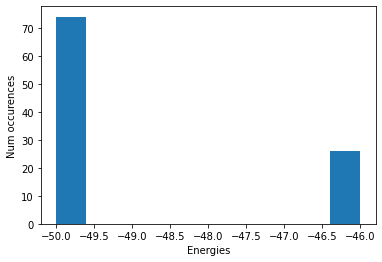

In [5]:
#Plot the energies found
import matplotlib.pyplot as plt

plt.hist(energies,weights=occurences)
plt.xlabel("Energies")
plt.ylabel("Num occurences")
plt.show()

## Number Partitioning
[5]

**Problem**: 

Split a set of numbers in two subsets such that the sums of the elements of each subset are as close as possible.

**Formulation**:

We start with the set of integers $s_i$. 

Let $x_i$ be 0 if $s_i$ belongs to subset 0, and 1 otherwise. Since we are considering binary variables, $x_i^2 = x_i$.

The sum of the elements in subset 1 is $sum_1 = \sum_i x_i s_i$.
The sum of the elements in subset 0 is $sum_0 = \sum_i s_i - sum_1 = c - sum_1$.

We want to minimize 
$$(sum_0-sum_1)^2 = (c - sum_1 - sum_1)^2 = $$

$$\left(c -  2\sum_i x_i s_i\right)^2  = c^2 -4c\sum_i x_i s_i + 4\left(\sum_i x_i s_i\right)^2 = 
$$

$$
c^2 -4c\sum_i x_i s_i + 4\sum_i x_i^2 s_i^2 + 4 \sum_i\sum_{j\neq i} x_ix_js_is_j =
$$

$$
c^2 + 4\sum_i x_i^2 (s_i^2 - cs_i) + 4 \sum_i\sum_{j\neq i} x_ix_js_is_j = c^2 +4\mathbf{x^TQx}
$$

We can drop the additive and multiplicative constants, and just minimize

$$ \sum_i q_{ii} x_i + \sum_i\sum_{j\neq i} q_{ij}x_ix_j,\quad q_{ii} =  s_i(s_i - c),\quad q_{ij} =  s_is_j$$

In [13]:
import numpy as np
from dimod import BinaryQuadraticModel

#Samplers
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

import dwave.inspector

In [14]:
#Generate list of random integers
numbers = np.random.randint(1,100, size=10)
c = numbers.sum()

print(numbers)

[92  3 86 52 24 75 67 35  3 62]


In [15]:
#Create Binary Quadratic Model and a matrix Q for visualization

bqm = BinaryQuadraticModel(len(numbers), vartype='BINARY')
Q = np.zeros((len(numbers), len(numbers)))

#Add linear terms
for i in range(len(numbers)):
    Q[i,i] = numbers[i]*(numbers[i]-c)/c
    bqm.add_linear(i, numbers[i]*(numbers[i]-c)/c)

#Add quadratic terms
for i in range(len(numbers)):
    for j in range(len(numbers)):
        if i == j: continue
        Q[i,j] = numbers[i]*numbers[j]/c
        bqm.add_quadratic(i, j , numbers[i]*numbers[j]/c)
        
# print(Q)

In [16]:
sampler = EmbeddingComposite(DWaveSampler()) #QPU sampler
# sampler = SimulatedAnnealingSampler() #Simulated annealing sampler
samples = sampler.sample(bqm, num_reads=20, label= "Number Partitioning")

In [10]:
#Inspect the problem
dwave.inspector.show(samples)

'http://127.0.0.1:18000/?problemId=2124c2e0-274f-474b-8f0c-b8734ceca52e'

Best partition found:
[92  3 86 67]
[52 24 75 35  3 62]

The respective sums are 248 and 251, which differ by 3


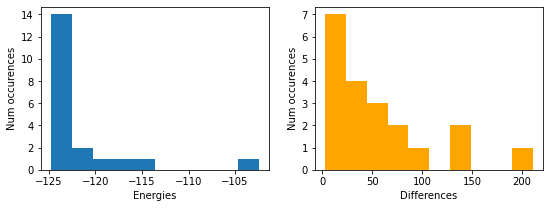

In [17]:
best = np.array(list(samples.lowest().first.sample.values()))
sum1 = numbers[best==1].sum()
sum0 = c - sum1

print(f"Best partition found:\n{numbers[best==0]}\n{numbers[best==1]}\n")
print(f"The respective sums are {sum0} and {sum1}, which differ by {abs(sum0-sum1)}")

energies = np.array([s.energy for s in samples.data()])
occurences = [s.num_occurrences for s in samples.data()]

differences = []
for s in samples.data():
    result = np.array(list(s.sample.values()))
    sum1 = numbers[result==1].sum()
    sum0 = c - sum1
    differences.append(abs(sum1-sum0))
    
fig, ax = plt.subplots(figsize=(9,3), ncols=2)
ax[0].hist(energies, weights = occurences)
ax[1].hist(differences, weights = occurences, color="orange")

ax[0].set(xlabel="Energies", ylabel="Num occurences")
ax[1].set(xlabel="Differences", ylabel="Num occurences")
plt.show()

50## **Traveling Salesman**
[6]

**Problem:** 

Find the shortest trajectory for visiting all $N$ nodes of a graph sequentially.

**Formulation:** 

Let $(a, t)$ be 1 if node/place $a$ is visited at time step $t$, and 0 otherwise.

We want to minimize $\displaystyle\sum_t\sum_{a \in \text{nodes}}\sum_{b \in \text{nodes}} d_{a, b} (a,t)\cdot(b,t+1)$ with the following constraints:

- $\displaystyle\sum_{a \in \text{nodes}} (a,t) = 1,\quad t=0,...,N-1$ 🠖 Can only visit any one place once
- $\displaystyle\sum_{t =0}^{N-1} (a,t) = 1,\quad a\in \text{nodes}$ 🠖 Can only be in one place at a time

We can add these constraints by penalizing them, as we will see in the code.

In [18]:
from dimod import BinaryQuadraticModel

#Helper functions for constraints
from dimod.generators.constraints import combinations
from itertools import permutations

#Samplers
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

import dwave.inspector

In [19]:
places = ["Pavilhão Central",
         "Torre Norte",
         "Torre Sul",
         "Pavilhão Matemática",
         "Pavilhão Civil",
         "Cantina"]

distances = {(0,1):91, (0,2): 91, (0,3):140, (0,4):98, (0,5):175,
             (1,2):175, (1,3):230, (1,4):107, (1,5):192,
             (2,3):100, (2,4):178, (2,5):157,
             (3,4):177, (3,5):258,
             (4,5):265,
            }

N = len(places)

In [20]:
# Returns the distance between place1 and place2
def get_distance(place1, place2):
    i = places.index(place1)
    j = places.index(place2)
    return distances[(min(i,j), max(i,j))]

Explicitly setting the quadratic penalties:

In [21]:
bqm = BinaryQuadraticModel("BINARY")

# The average route distance will be a good measure of the strength of the constraints
avg_distance = 2*sum(distances.values())/(N-1)

# Can only visit one place once
for place in places:
    for t in range(N):
        bqm.add_variable((place, t))
        bqm.add_linear((place,t), -avg_distance)  
        for j in range(t+1, N):
            bqm.add_quadratic((place,t), (place,j), 2*avg_distance)
            
# Can only be one place at a time
for t in range(N):
    for place in places:
        bqm.add_linear((place,t), -avg_distance)
        for place2 in places:
            if place == place2: continue
            bqm.add_quadratic((place,t), (place2,t), avg_distance)

#Setting the distance between places            
for place1, place2 in permutations(places, 2):
    for t in range(N):
        t_next = (t + 1) % N
        bqm.add_quadratic((place1,t), (place2,t_next), get_distance(place1,place2))

Using the `combinations` function:

In [27]:
bqm = BinaryQuadraticModel("BINARY")

# The average route distance will be a good measure of the strength of the constraints
avg_distance = 2*sum(distances.values())/(N-1)

# Can only visit one place once
for place in places:
    possible = [(place,t) for t in range(N)]
    possible_comb = combinations(possible, 1, strength=avg_distance)
    bqm.update(possible_comb)

# Can only be one place at a time
for t in range(N):
    possible = [(place,t) for place in places]
    possible_comb = combinations(possible, 1, strength=avg_distance)
    bqm.update(possible_comb)

#Setting the distance between places            
for place1, place2 in permutations(places, 2):
    for t in range(N):
        t_next = (t + 1) % N
        bqm.add_quadratic((place1,t), (place2,t_next), get_distance(place1,place2))

Sample and show lowest energy solution:

In [22]:
# sampler = neal.SimulatedAnnealingSampler() #Simulated annealing
sampler = EmbeddingComposite(DWaveSampler()) #QPU sampler

samples = sampler.sample(bqm, num_reads=150, label="Traveling Salesman")

solution = samples.lowest().first.sample

route = [i for i in solution if solution[i]]
route.sort(key=lambda x: x[1])

final_distance = sum([get_distance(i[0],j[0]) for i,j in zip(route,route[1:]+[route[0]])])

print(f"Energy: {samples.lowest().first.energy:.3f}")
print(" -> ".join([x[0] for x in route]))
print(f"Distance: {final_distance} m")

Energy: -10889.200
Torre Norte -> Pavilhão Civil -> Pavilhão Central -> Pavilhão Matemática -> Torre Sul -> Cantina
Distance: 794 m


In [23]:
#Inspect the problem
dwave.inspector.show(samples)  

'http://127.0.0.1:18000/?problemId=72c81537-4919-42e5-8428-577c36b8818c'

Show all solutions

In [24]:
#Show all solutions
for _, solution in zip(range(10),samples.aggregate().data()):
    result = solution.sample
    route = [i for i in result if result[i]]
    route.sort(key=lambda x: x[1])

    try:
        final_distance = sum([get_distance(i[0],j[0]) for i,j in zip(route,route[1:]+[route[0]])])
    except Exception as e:
        print("Invalid Solution")
        continue
    
    print("Valid Solution" if len(route)==len(set(route))==6 else "Invalid Solution")
    print(f"Number of occurrences: {solution.num_occurrences}")
    print(f"Distance: {final_distance} m")
    print(f"Energy: {solution.energy}")
    print(" -> ".join([x[0] for x in route]) + "\n")

Valid Solution
Number of occurrences: 1
Distance: 794 m
Energy: -10889.2
Torre Norte -> Pavilhão Civil -> Pavilhão Central -> Pavilhão Matemática -> Torre Sul -> Cantina

Valid Solution
Number of occurrences: 1
Distance: 881 m
Energy: -10802.2
Pavilhão Matemática -> Pavilhão Civil -> Torre Norte -> Pavilhão Central -> Torre Sul -> Cantina

Valid Solution
Number of occurrences: 1
Distance: 983 m
Energy: -10700.2
Pavilhão Central -> Cantina -> Pavilhão Matemática -> Pavilhão Civil -> Torre Norte -> Torre Sul

Valid Solution
Number of occurrences: 1
Distance: 987 m
Energy: -10696.2
Torre Sul -> Pavilhão Central -> Torre Norte -> Cantina -> Pavilhão Matemática -> Pavilhão Civil

Valid Solution
Number of occurrences: 1
Distance: 987 m
Energy: -10696.2
Torre Sul -> Pavilhão Matemática -> Cantina -> Pavilhão Civil -> Pavilhão Central -> Torre Norte

Valid Solution
Number of occurrences: 1
Distance: 1036 m
Energy: -10647.2
Pavilhão Matemática -> Cantina -> Pavilhão Civil -> Torre Norte -> Torr

# Conclusions 

- Quantum annealing is a very promising model of Quantum Computation that, in the future, could prove really useful for certain tasks.
- A lot of work still remains to be done in this area;
- There are tools publicly available that allow for an easy and fast interaction with Quantum Processing Units capable of solving some optimization problems.


# References
- [1] John Preskill. “Quantum Computing in the NISQ era and beyond”. In: Quantum 2 (Aug. 2018), p. 79. issn: 2521-327X. doi: 10.22331/q-2018-08-06-79. url: http://dx.doi.org/10.22331/q-2018-08-06-79.

- [2] Elisabeth Lobe and Annette Lutz. Minor Embedding in Broken Chimera and Pegasus Graphs
is NP-complete. 2021. arXiv: 2110.08325 [quant-ph].

- [3] DWave Ocean Software Documentation. Jan. 2022. url: https://docs.ocean.dwavesys.com/.

- [4] Raúl Santos. “Introduction to Adiabatic Quantum Computation”. In: *Introduction to Quantum Information and Computation, 2021/22*. Instituto Superior Técnico, Universidade de Lisboa. Jan. 2022.

- [5] Fred Glover, Gary Kochenberger, and Yu Du. A Tutorial on Formulating and Using QUBO Models. 2019. arXiv: 1811.11538 [cs.DS].

- [6] Bettina Heim et al. Designing Adiabatic Quantum Optimization: A Case Study for the Traveling Salesman Problem. 2017. arXiv: 1702.06248 [quant-ph].